### **Overview**

This notebooks contains tools for preprocessing and visualization of the Walaris dataset for flight trajectories, given as Json files.\

Preprocessing includes:
- Reading the relevant fields from the Json file
- Converting the position unit vectors into two independent angles (azimuth and elevation)
- Cleaning the data, replacing outliers with smoothed values
- Data interpolation. Since there are sometimes significant time gaps in the data, we can interpolate it in the expected sampling rate, which can be useful for some applications of analysis

Visualization functions include:
- **plot_vs_time**: plots a 2X1 plot with data vs time for azimuth and elevation at the requested stage of processing.
- **plot_3d_and_2d_angles**: Presenting the different processing stages per one file
- **plot file**: Helper funtion to plot any chosen stage of processing for one file using the given figure axe.
- **plot_random_files**: Sampling a few files from each label and plotting a chosen stage of processing to observe the different nature of the behavior in each label
- **plot_folder**: Plotting a chosen stage of processing for all files in a folder

### Imports and loading

In [ ]:
# imports

import io
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.interpolate import interp1d

# Machine Learning
from sklearn.decomposition import PCA


# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


### Raw Data

In [ ]:
def convert_to_angles(xx, yy, zz, ang = 'deg'):
  """
  Converts the position unit vectors into two independent angles (azimuth and elevation).
  """
  theta = np.arctan2(yy, xx)
  # phi = np.arctan2(zz, np.sqrt(xx**2 + yy**2))
  phi = np.arcsin(zz)
  if ang == 'deg':
      theta = np.rad2deg(theta)
      phi = np.rad2deg(phi)
  return theta, phi

In [ ]:
def raw_angles_data_from_json(file_path):
  """
  Reads the relevant fields from the Json file:
  - timestamp
  - position_xyz - also converting to angles
  - angular_size_hor_ver
  - light_domain

  """
  with open(file_path) as f:
      data = json.load(f)

  tt = []
  xx = []
  yy = []
  zz = []
  size_hor = []
  size_ver = []
  light_domain = data['light_domain']

  for r in data['track_data']:
    tt.append(r['timestamp'])
    xx.append(r['position_xyz'][0])
    yy.append(r['position_xyz'][1])
    zz.append(r['position_xyz'][2])
    size_hor.append(r['angular_size_hor_ver'][0])
    size_ver.append(r['angular_size_hor_ver'][1])


  tt = np.array(tt)
  tt = np.array(tt).astype(float)
  tt = tt-tt[0] # time will start from 0
  xx = np.array(xx)
  yy = np.array(yy)
  zz = np.array(zz)
  theta, phi = convert_to_angles(xx, yy, zz)
  size_hor = np.array(size_hor).astype(float)
  size_ver = np.array(size_ver).astype(float)

  return tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain

### Data Cleaning

In [ ]:
def local_std(data, window = 10):
  """
  This function returns the typical local standard deviation of an array for the purpose:
  1. Finding outliers
  2. Indicating the scale of the sample
  It calculates the standard deviation on a rolling window and returns the median of all standard deviations.
  """
  data = pd.Series(data)
  rolling_std = data.rolling(window).std()
  return rolling_std.median()


In [ ]:
def split_time_vector(time_vector, dt):
  """
  Splits a time vector into segments where the time interval is greater than dt.
  This enables us to process each segment for outliers and cleaning by itself.
  """
  segments = []
  start_ind = 0
  for end_ind in range(1, len(time_vector)):
    if time_vector[end_ind] - time_vector[end_ind-1] > dt:
      segments.append([start_ind, end_ind])
      start_ind = end_ind
  segments.append([start_ind, end_ind+1])

  return segments

In [ ]:
def clean_data(data, factor = 3, window = 5, threshold = -999, replace_by = 'med'):
  """
  Cleans the data by replacing outliers by values obtained by a low-pass value or median filter

  Args:
    data: A one dimensional array of data.
    threshold: Should reflect the expected local std of the data. If not given it is calculated
    factor: How many std deviations are considered as outliers. The default is 3.
    window: The window of the convolution used for low-pass/median filtering.

  Returns:
    A cleaned version of the data.
  """
  # determine std threshold
  if threshold == -999:
    threshold = local_std(data, 2*window)

  if replace_by == 'lp':
    # Run a low pass filter.
    padded_data = np.pad(data, (window//2, window//2), 'edge')
    replacement_data = np.convolve(padded_data, np.ones(window) / window, mode='valid')
  elif replace_by == 'med':
    # Run a median filter.
    replacement_data = median_filter(data, size=window, mode='nearest')

  # Replace points with large deviations (3 times estimated std).
  cleaned_data = np.where(np.abs(data - replacement_data) > factor*threshold, replacement_data, data)

  return cleaned_data


In [ ]:
def clean_3D_data_w_split(time, data_x, data_y, data_z, factor = 3, window = 5, threshold = -999, replace_by = 'med'):
  """
  Cleans the data by replacing outliers by values obtained by a low-pass value.
  Outliers deviation is calculated in 3D
  The data is first splitted into segments to be cleaned separately if time gaps are too large.
  Perhaps to be changed to median filtering...

  Args:
    time: timestamps vector - for splitting if necessary
    data:  3 arrays of position data.
    threshold: Should reflect the expected local 3D std of the data. If not given it is calculated by weighting the local std of all dimensions
    factor: How many std deviations are considered as outliers. The default is 3.
    window: The window of the convolution used for low-pass filtering.

  Returns:
    A cleaned version of the data.
  """
  split_dt = 0.3 # 300 msec
  time_segments = split_time_vector(time, split_dt)

  cleaned_data_x = []
  cleaned_data_y = []
  cleaned_data_z = []

  for seg in time_segments:
    seg_data_x = data_x[seg[0]:seg[1]]
    seg_data_y = data_y[seg[0]:seg[1]]
    seg_data_z = data_z[seg[0]:seg[1]]

    # determine std threshold
    if threshold == -999:
      std_x = local_std(seg_data_x, 2*window)
      std_y = local_std(seg_data_y, 2*window)
      std_z = local_std(seg_data_z, 2*window)
      threshold = np.sqrt(std_x**2 + std_y**2 + std_z**2)

    if replace_by == 'lp':
    # Run a low pass filter.
      padded_data_x = np.pad(seg_data_x, (window//2, window//2), 'edge')
      rep_data_x = np.convolve(padded_data_x, np.ones(window) / window, mode='valid')
      padded_data_y = np.pad(seg_data_y, (window//2, window//2), 'edge')
      rep_data_y = np.convolve(padded_data_y, np.ones(window) / window, mode='valid')
      padded_data_z = np.pad(seg_data_z, (window//2, window//2), 'edge')
      rep_data_z = np.convolve(padded_data_z, np.ones(window) / window, mode='valid')
      # Replace points with large deviations (3 times estimated std).

    elif replace_by == 'med':
    # Run a median filter.
      rep_data_x = median_filter(seg_data_x, size=window, mode='nearest')
      rep_data_y = median_filter(seg_data_y, size=window, mode='nearest')
      rep_data_z = median_filter(seg_data_z, size=window, mode='nearest')

    total_deviation = np.sqrt((seg_data_x-rep_data_x)**2 + (seg_data_y-rep_data_y)**2 + (seg_data_z-rep_data_z)**2)

    seg_cleaned_data_x = np.where(total_deviation > factor*threshold, rep_data_x, seg_data_x)
    seg_cleaned_data_y = np.where(total_deviation > factor*threshold, rep_data_y, seg_data_y)
    seg_cleaned_data_z = np.where(total_deviation > factor*threshold, rep_data_z, seg_data_z)
    cleaned_data_x.extend(seg_cleaned_data_x)
    cleaned_data_y.extend(seg_cleaned_data_y)
    cleaned_data_z.extend(seg_cleaned_data_z)
  return np.array(cleaned_data_x), np.array(cleaned_data_y), np.array(cleaned_data_z)

In [ ]:
def clean_2D_data_w_split(time, data_theta, data_phi, factor = 3, window = 5, threshold = -999, replace_by = 'med'):
  """
  Cleans the data by replacing outliers by values obtained by a low-pass value.
  Outliers deviation is calculated in 2D
  The data is first splitted into segments to be cleaned separately if time gaps are too large.
  Perhaps to be changed to median filtering...

  Args:
    time: timestamps vector - for splitting if necessary
    data:  2 arrays of position data (angles).
    threshold: Should reflect the expected local 2D std of the data. If not given it is calculated by weighting the local std of all dimensions
    factor: How many std deviations are considered as outliers. The default is 3.
    window: The window of the convolution used for low-pass filtering.

  Returns:
    A cleaned version of the data.
  """
  split_dt = 0.3 # 300 msec
  time_segments = split_time_vector(time, split_dt)

  cleaned_data_theta = []
  cleaned_data_phi = []

  for seg in time_segments:
    seg_data_theta = data_theta[seg[0]:seg[1]]
    seg_data_phi = data_phi[seg[0]:seg[1]]
    # determine std threshold
    if threshold == -999:
      std_theta = local_std(seg_data_theta, 2*window)
      std_phi = local_std(seg_data_phi, 2*window)
      threshold = np.sqrt(std_theta**2 + std_phi**2)

    if replace_by == 'lp':
    # Run a low pass filter.
      padded_data_theta = np.pad(seg_data_theta, (window//2, window//2), 'edge')
      rep_data_theta = np.convolve(padded_data_theta, np.ones(window) / window, mode='valid')
      padded_data_phi = np.pad(seg_data_phi, (window//2, window//2), 'edge')
      rep_data_phi = np.convolve(padded_data_phi, np.ones(window) / window, mode='valid')
    elif replace_by == 'med':
    # Run a median filter.
      rep_data_theta = median_filter(seg_data_theta, size=window, mode='nearest')
      rep_data_phi = median_filter(seg_data_phi, size=window, mode='nearest')

    # Replace points with large deviations (3 times estimated std).
    total_deviation = np.sqrt((seg_data_theta-rep_data_theta)**2 + (seg_data_phi-rep_data_phi)**2)
    seg_cleaned_data_theta = np.where(total_deviation > factor*threshold, rep_data_theta, seg_data_theta)
    seg_cleaned_data_phi = np.where(total_deviation > factor*threshold, rep_data_phi, seg_data_phi)
    cleaned_data_theta.extend(seg_cleaned_data_theta)
    cleaned_data_phi.extend(seg_cleaned_data_phi)
  return np.array(cleaned_data_theta), np.array(cleaned_data_phi)


### Interpolation

In [ ]:
def interpolate_data(time, values, dt=0.04, fixed = False):
  """
  Interpolates data in a time series.
  If fixed is True, interpolation is done in fixed intervals along the entire time
  If False, only places with gaps larger than 2*dt are interpolated with dt steps

  Args:
    time: A one dimensional array of time values.
    values: A one dimensional array of values.
    dt: The time interval for interpolation.

  Returns:
    An interpolated version of the data.
  """
  if fixed:
    new_time = np.arange(time[0], time[-1], dt)
  else:
    new_time = []
    for t, t_plus in zip(time[:-1], time[1:]):
      if t_plus - t > 2*dt:
        new_time.extend(np.arange(t, t_plus-dt, dt))
      else:
        new_time.append(t)
    new_time.append(time[-1])

  return np.array(new_time), np.interp(new_time, time, values)

### Visualization

In [ ]:
def plot_vs_time(file_path, plot_type = 'angles',start = 0, finish = -999):
  """
  Plots the desired property vs time for both the azimuth and elevation axis.
  The options are:
  'angles': plotting theta and phi angles
  'vel': plotting the time derivative of the angles
  'acc': plotting the 2nd time derivative of the angles
  """
  tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain = raw_angles_data_from_json(file_path)

  if finish == -999:
    start = 0
    finish = len(tt)

  cleaned_theta, cleaned_phi = clean_2D_data_w_split(tt, theta, phi, factor = 3, window = 5, threshold = -999, replace_by = 'med')
  delta = 0.04
  new_tt, interp_theta = interpolate_data(tt, cleaned_theta, dt=delta, fixed = False)
  new_tt, interp_phi = interpolate_data(tt, cleaned_phi, dt=delta, fixed = False)

  #to plot the same span as not interpolated - find the right time marker
  new_finish = np.nonzero(new_tt>=tt[finish-1])[0][0]
  print(new_finish)


  fig = plt.figure(figsize = [4,4])
  if plot_type == 'angles':
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(new_tt[start:new_finish], interp_theta[start:new_finish], label='theta', color='blue')
    ax1.set_xlabel('Time [sec]')
    ax1.set_ylabel('Azimuth [deg]')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(new_tt[start:new_finish], interp_phi[start:new_finish], label='phi', color='green')
    ax2.set_xlabel('Time [sec]')
    ax2.set_ylabel('Elevation [deg]')
  else:
    vel_theta = np.diff(interp_theta)/np.diff(new_tt)
    vel_phi = np.diff(interp_phi)/np.diff(new_tt)
    t_vel = (new_tt[:-1] + new_tt[1:])/2

    if plot_type == 'vel':
      ax1 = fig.add_subplot(2, 1, 1)
      ax1.plot(t_vel[start:new_finish-1], vel_theta[start:new_finish-1], label='vel theta', color='blue')
      ax1.set_xlabel('Time [sec]')
      ax1.set_ylabel('Azimuth Velocity [dps]')
      ax2 = fig.add_subplot(2, 1, 2)
      ax2.plot(t_vel[start:new_finish-1], vel_phi[start:new_finish-1], label='vel phi', color='green')
      ax2.set_xlabel('Time [sec]')
      ax2.set_ylabel('Elevation Velocity [dps]')
    elif plot_type == 'acc':
      acc_theta = np.diff(vel_theta)/np.diff(t_vel)
      acc_phi = np.diff(vel_phi)/np.diff(t_vel)
      t_acc = (t_vel[:-1] + t_vel[1:])/2
      ax1 = fig.add_subplot(2, 1, 1)
      ax1.plot(t_acc[start:new_finish-2], acc_theta[start:new_finish-2], label='acc theta', color='blue')
      ax1.set_xlabel('Time [sec]')
      ax1.set_ylabel('Azimuth Acceleration [dps/s]')
      ax2 = fig.add_subplot(2, 1, 2)
      ax2.plot(t_acc[start:new_finish-2], acc_phi[start:new_finish-2], label='acc phi', color='green')
      ax2.set_xlabel('Time [sec]')
      ax2.set_ylabel('Elevation Acceleration [dps/s]')

2393


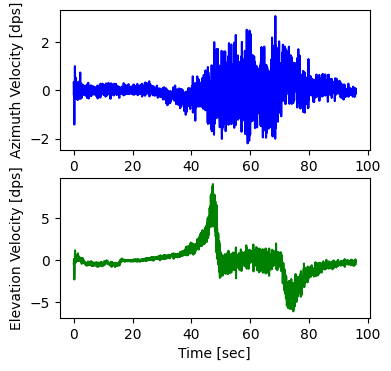

In [ ]:
# file_path = "track_data/uav/VIS_uav_20230605-108_20230605-130248.json"
# file_path = "track_data/bird/VIS_bird_20230605-406_20230605-142825.json"
# file_path = "track_data/airplane/VIS_airplane_20231023-6210_20231023-162937.json"
# file_path = "track_data/airplane/VIS_airplane_20231025-21925_20231025-074948.json"
file_path = "track_data/uav/VIS_uav_20231027-10903_20231027-114017.json"
plot_vs_time(file_path, 'vel')
# plot_vs_time(file_path, 'angles')

In [ ]:
def plot_3d_and_2d_angles(file_path, start = 0, finish = -999):
  """
  Plots the different preprocessing stages for a single file
  Zoom into the plot by specifying the start and end indices
  """
  tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain = raw_angles_data_from_json(file_path)

  if finish == -999:
      start = 0
      finish = len(tt)

  fig = plt.figure(figsize = [10,10])
  ax1 = fig.add_subplot(2, 2, 1, projection='3d')
  ax1.plot(xx[start:finish], yy[start:finish], zz[start:finish], '.-b', label='Position')
  ax1.set_title('Raw xyz Data')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.set_zlabel('z')
  plt.legend()
  #plot cleaned data
  cleaned_theta, cleaned_phi = clean_2D_data_w_split(tt, theta, phi, factor = 3, window = 5, threshold = -999, replace_by = 'med')

  ax2 = fig.add_subplot(2, 2, 2)
  ax2.plot(cleaned_theta[start:finish], cleaned_phi[start:finish], '.-g', label='Angles')
  ax2.set_title('Cleaned Angles Data')
  ax2.set_xlabel('Azimuth [deg]')
  ax2.set_ylabel('Elevation [deg]')
  plt.legend()
  #plot interpolation
  delta = 0.04
  new_tt, interp_theta = interpolate_data(tt, cleaned_theta, dt=delta, fixed = False)
  new_tt, interp_phi = interpolate_data(tt, cleaned_phi, dt=delta, fixed = False)

  #to plot the same span as not interpolated - find the right time marker
  new_finish = np.nonzero(new_tt>=tt[finish-1])[0][0]
  ax3 = fig.add_subplot(2, 2, 3)
  ax3.plot(interp_theta[start:new_finish], interp_phi[start:new_finish], '.-r', label='Interploated angles')
  ax3.set_title('Interpolated Data')
  ax3.set_xlabel('Azimuth [deg]')
  ax3.set_ylabel('Elevation [deg]')
  plt.legend()
  #plot elevation derivative
  # vel_theta = np.diff(interp_theta)/np.diff(new_tt)
  vel_phi = np.diff(interp_phi)/np.diff(new_tt)
  t_vel = (new_tt[:-1] + new_tt[1:])/2

  ax4 = fig.add_subplot(2, 2, 4)
  ax4.plot(t_vel[start:new_finish-1], vel_phi[start:new_finish-1], '.-m', label='vel phi')
  ax4.set_title('Elevation Derivative')
  ax4.set_xlabel('Azimuth [deg]')
  ax4.set_ylabel('Elevation [deg]')
  plt.legend()

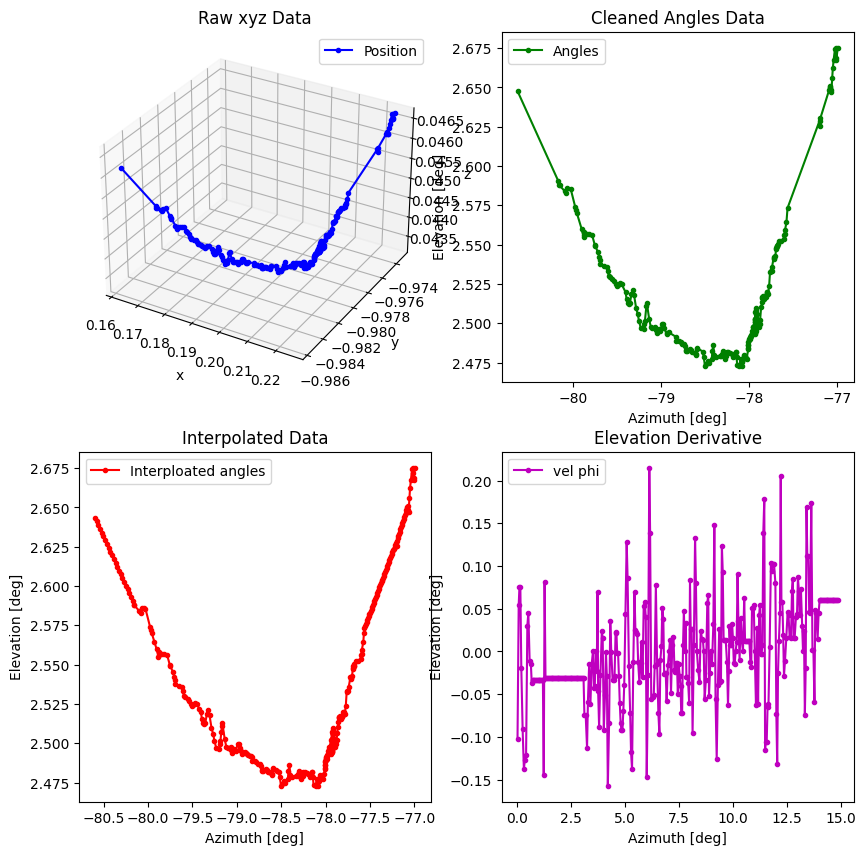

In [ ]:
# plot_3d_and_2d(xx, yy, zz, vx, vy, vz)
file_path = "track_data/uav/VIS_uav_20230605-108_20230605-130248.json"
# file_path = "track_data/bird/VIS_bird_20230605-406_20230605-142825.json"
# file_path = "track_data/airplane/VIS_airplane_20231023-6210_20231023-162937.json"
# file_path = "track_data/airplane/VIS_airplane_20231025-21925_20231025-074948.json"
plot_3d_and_2d_angles(file_path)

In [ ]:
def plot_file(file_path, plot_type, ax):
  """
  Plots the requested view for one file on the given axe
  """

  tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain = raw_angles_data_from_json(file_path)

  if plot_type == 'raw':
    # ax.scatter(xx, yy, zz, label='Raw Position', color='blue')
    ax.plot(xx, yy, zz,'.-b')#, label='Raw Position')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # plt.legend()
  else:
    cleaned_theta, cleaned_phi = clean_2D_data_w_split(tt, theta, phi, factor = 3, window = 5, threshold = -999, replace_by = 'med')
    if plot_type == 'cleaned':
      # ax.scatter(cleaned_theta, cleaned_phi, label='Clean Angles', color='blue')
      ax.plot(cleaned_theta, cleaned_phi,'.-b')#, label='Clean Angles')
      ax.set_xlabel('Azimuth [deg]')
      ax.set_ylabel('Elevation [deg]')
      # plt.legend()
    else:
      delta = 0.04
      new_tt, interp_theta = interpolate_data(tt, cleaned_theta, dt=delta, fixed = False)
      new_tt, interp_phi = interpolate_data(tt, cleaned_phi, dt=delta, fixed = False)
      if plot_type == 'full':
        ax.plot(interp_theta, interp_phi,'.-b')#, label='Interploated Angles')
        ax.set_xlabel('Azimuth [deg]')
        ax.set_ylabel('Elevation [deg]')
        # plt.legend()
      else:
        # vel_theta = np.diff(interp_theta)/.np.diff(new_tt)
        vel_phi = np.diff(interp_phi)/np.diff(new_tt)
        t_vel = (new_tt[:-1] + new_tt[1:])/2

        if plot_type == 'vel':
          # ax.plot(new_tt[:-1], vel_theta, label='vel theta', color='blue')
          ax.plot(t_vel, vel_phi, label='vel theta', color='blue')
          ax.set_xlabel('Azimuth Velocity [dps]')
          ax.set_ylabel('Elevation Velocity[dps]')

        elif plot_type == 'acc':
          acc_phi = np.diff(vel_phi)/np.diff(t_vel)
          # acc_theta = np.diff(vel_theta)/np.diff(t_vel)
          t_acc = (t_vel[:-1] + t_vel[1:])/2
          # ax.plot(new_tt[:-2], acc_theta, label='acc theta', color='blue')
          ax.plot(t_acc, acc_phi, label='acc theta', color='blue')
          ax.set_xlabel('Azimuth Acceleration[dps/s]')
          ax.set_ylabel('Elevation Acceleration [dps/s]')



In [ ]:
def plot_random_files(folder, plot_type = 'full'):
  """
  Samples 3 files randomly from each label and plots the requested plot type for all
  5 type of plots:
  3D : 'raw'
  2D : 'cleaned'
        'full' = cleaned and interpolated
        'vel' - the time derivative of the phi angle
        'acc' - the time 2nd derivative of the phi angle
  """
  fig = plt.figure(figsize = [10,15])
  subfolders = os.listdir(folder)
  # subfolders_ind = [0, 1, 2, 3, 4]
  subfolders_ind = [0, 1, 2, 3]
  subfolders_list = [subfolders[i] for i in subfolders_ind]
  n_subfolders = len(subfolders_list)
  # fig, axs = plt.subplots(5, 3)
  for i, subfolder in enumerate(subfolders_list):
      subfolder_path = os.path.join(folder, subfolder)
      files = os.listdir(subfolder_path)
      files = np.random.choice(files, 3, replace=False)
      for j, file in enumerate(files, start = 1):
          file_path = os.path.join(subfolder_path, file)
          if plot_type == 'raw':
            ax = fig.add_subplot(n_subfolders, 3, i*3+j, projection='3d')
          else:
            ax = fig.add_subplot(n_subfolders, 3, i*3+j)
          plot_file(file_path, plot_type, ax)
          ax.set_title(subfolder + '-' + plot_type)
  fig.tight_layout()
  plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


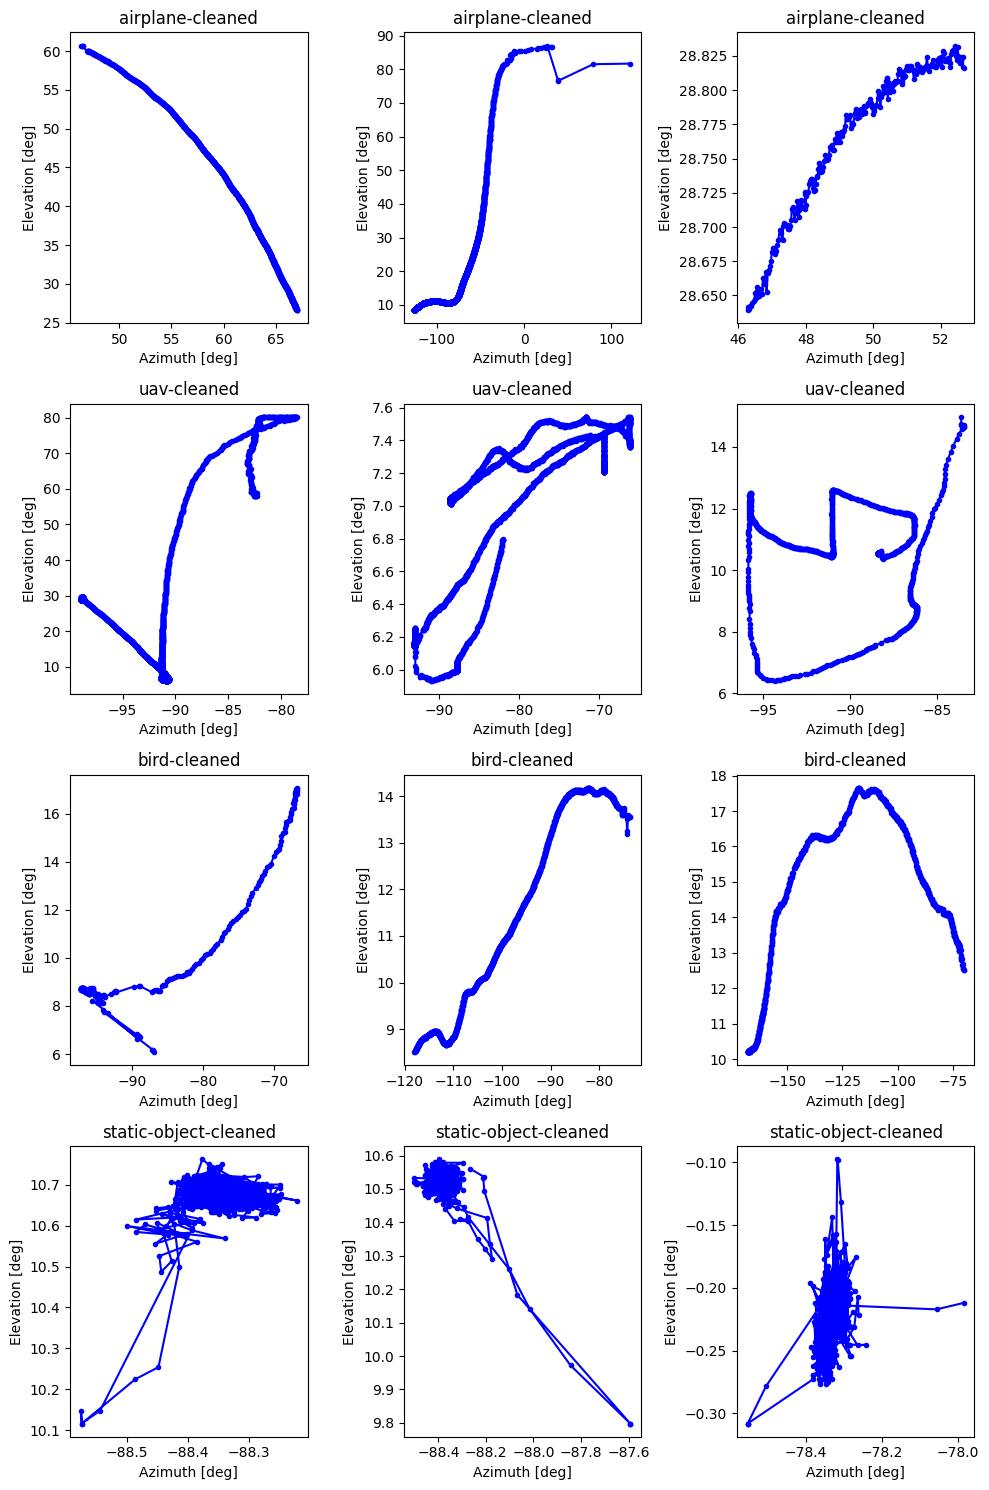

In [ ]:
plot_random_files("track_data", 'cleaned')

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


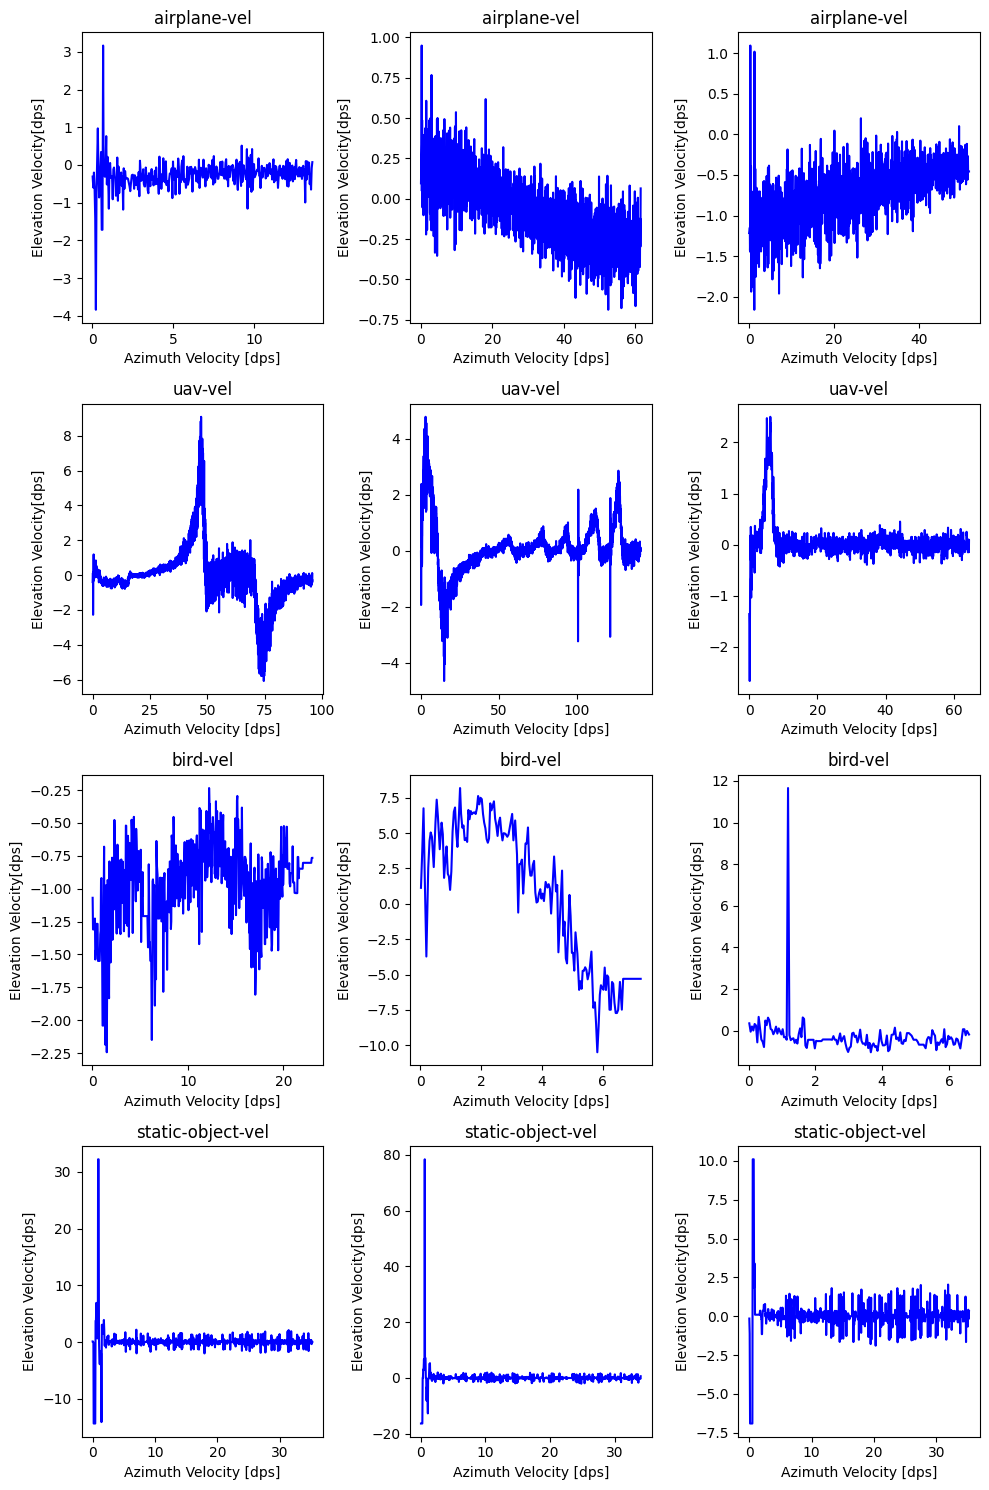

In [ ]:
plot_random_files("track_data", 'vel')

In [ ]:
def plot_random_files2(folder, plot_type = 'full'):
  """
  Samples 3 files randomly from each label and plots the requested plot type for all
  5 type of plots:
  3D : 'raw'
  2D : 'cleaned'
        'full' = cleaned and interpolated
        'vel' - the time derivative of the phi angle
        'acc' - the time 2nd derivative of the phi angle
  """
  # fig = plt.figure(figsize = [8,12])
  fig = plt.figure(figsize = [12,8])
  subfolders = os.listdir(folder)
  # subfolders_ind = [0, 1, 2, 3, 4]
  subfolders_ind = [0, 1, 2, 3]
  subfolders_list = [subfolders[i] for i in subfolders_ind]
  n_subfolders = len(subfolders_list)
  # fig, axs = plt.subplots(5, 3)
  # for i, subfolder in enumerate(subfolders_list, start = 0):
  for i, subfolder in enumerate(subfolders_list, start = 1):
      subfolder_path = os.path.join(folder, subfolder)
      files = os.listdir(subfolder_path)
      files = np.random.choice(files, 3, replace=False)
      # for j, file in enumerate(files, start = 1):
      for j, file in enumerate(files, start = 0):
          file_path = os.path.join(subfolder_path, file)
          if plot_type == 'raw':
            # ax = fig.add_subplot(n_subfolders, 3, i*3+j, projection='3d')
            ax = fig.add_subplot(3, n_subfolders, j*4+i, projection='3d')
          else:
            # ax = fig.add_subplot(n_subfolders, 3, i*3+j)
            ax = fig.add_subplot(3, n_subfolders, j*4+i)
          plot_file(file_path, plot_type, ax)
          ax.set_xlabel('Azimuth [deg]', fontsize=10)
          ax.set_ylabel('Elevation [deg]', fontsize=10)
          ax.set_title(subfolder +' ' +str(j+1))
  fig.tight_layout()
  plt.show()

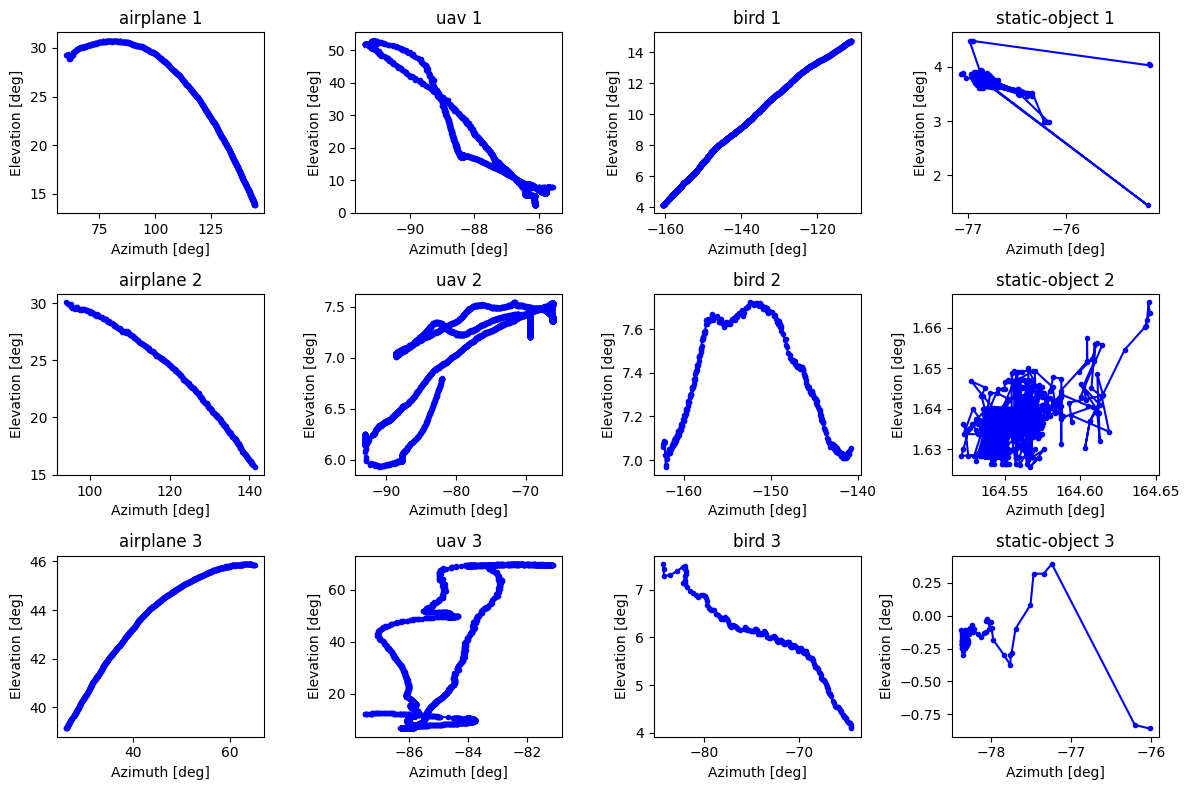

In [ ]:
plot_random_files2("track_data", 'cleaned')

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


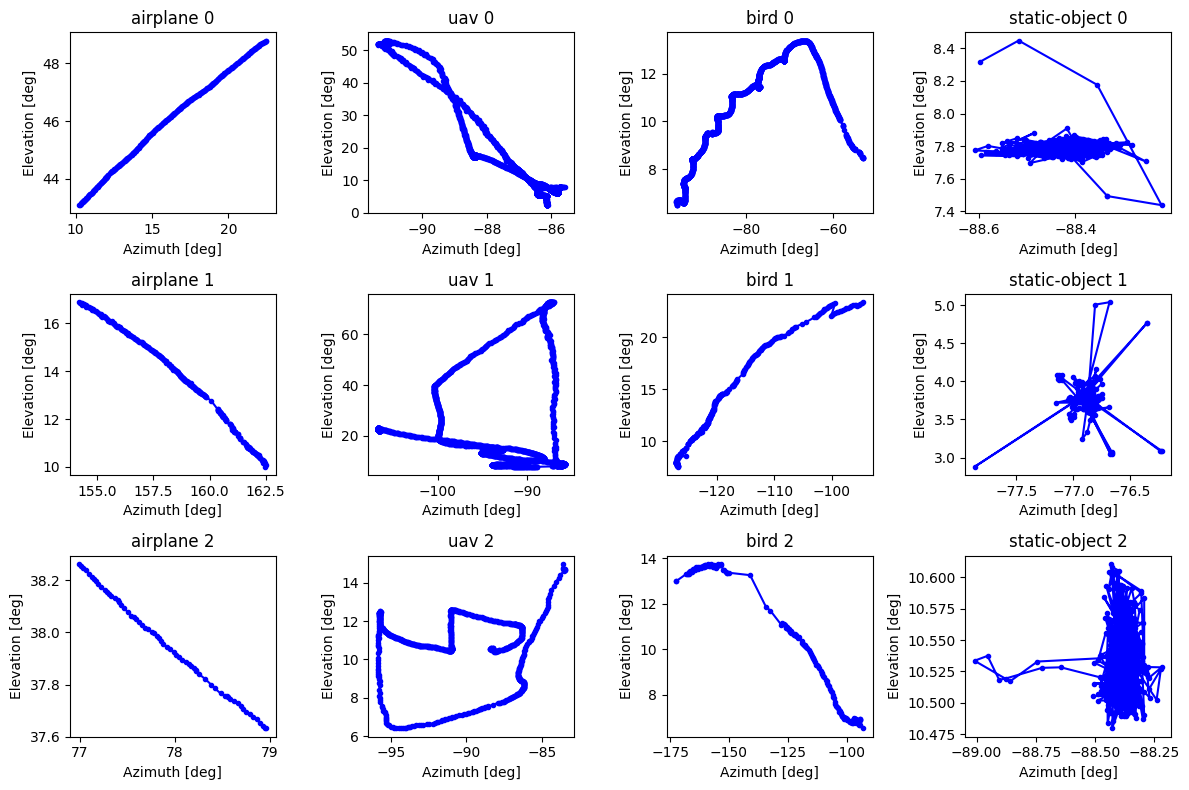

In [ ]:
plot_random_files2("track_data", 'cleaned')

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local

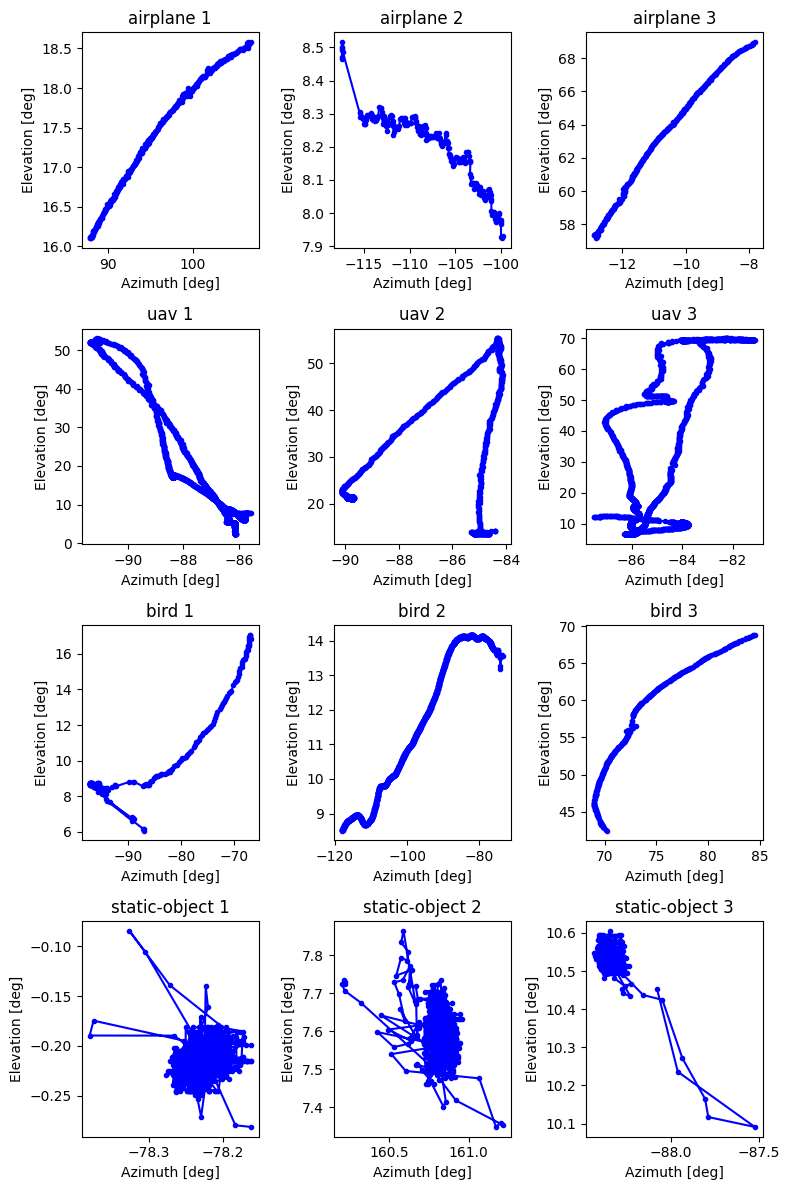

In [ ]:
plot_random_files2("track_data", 'cleaned')

In [ ]:
def plot_subfolder(subfolder, plot_type = 'full'):
    """
    print the requested plot_type for all files in the folder (intended for the smaller folders)
    5 type of plots:
    3D : 'raw'
    2D : 'cleaned'
         'full' = cleaned and interpolated
         'vel' - the time derivative of the phi angle
         'acc' - the time 2nd derivative of the phi angle
    """
    # fig = plt.figure(figsize = [10,20])
    # fig, axs = plt.subplots(5, 3)
    subfolder_path = os.path.join("track_data", subfolder)
    files = os.listdir(subfolder_path)
    p = np.floor(np.sqrt(len(files))).astype(int)+1
    fig, axs = plt.subplots(figsize = [15,20])
    for j, file in enumerate(files, start = 1):
        file_path = os.path.join(subfolder_path, file)
        if plot_type == 'raw':
          ax = fig.add_subplot(p, p, j, projection='3d')
        else:
          ax = fig.add_subplot(p, p, j)
        plot_file(file_path, plot_type, ax)
        # ax.set_title(subfolder + '-' + plot_type)
    fig.tight_layout()
    plt.suptitle(subfolder + ' subfolder -' + plot_type, y = 1.01, fontsize=20)
    plt.show()

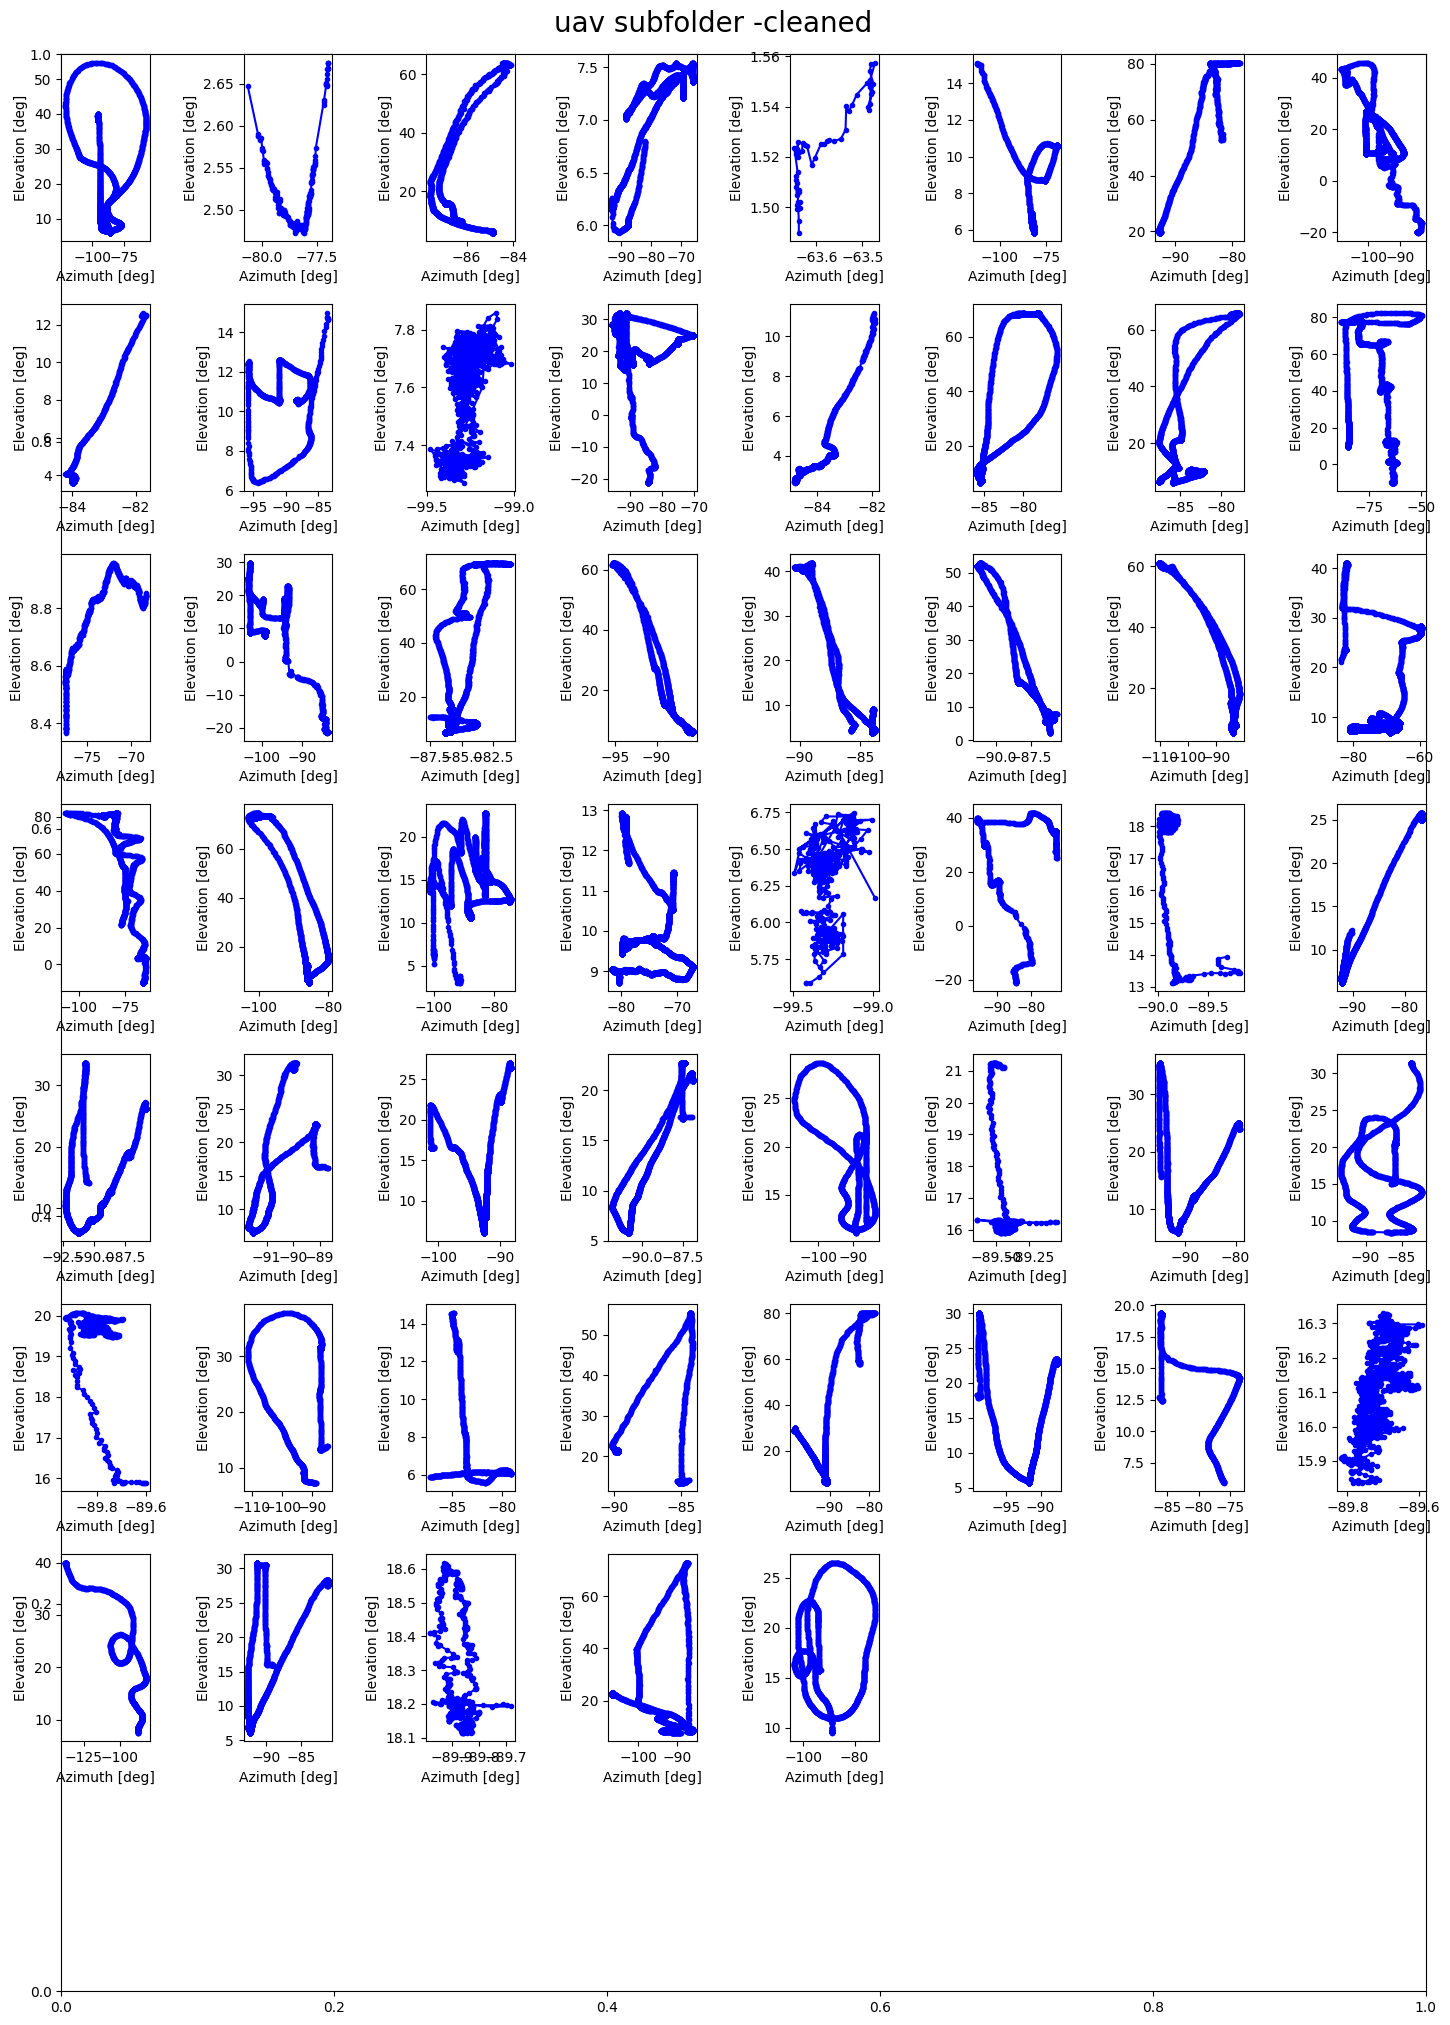

In [ ]:
plot_subfolder("uav", 'cleaned')

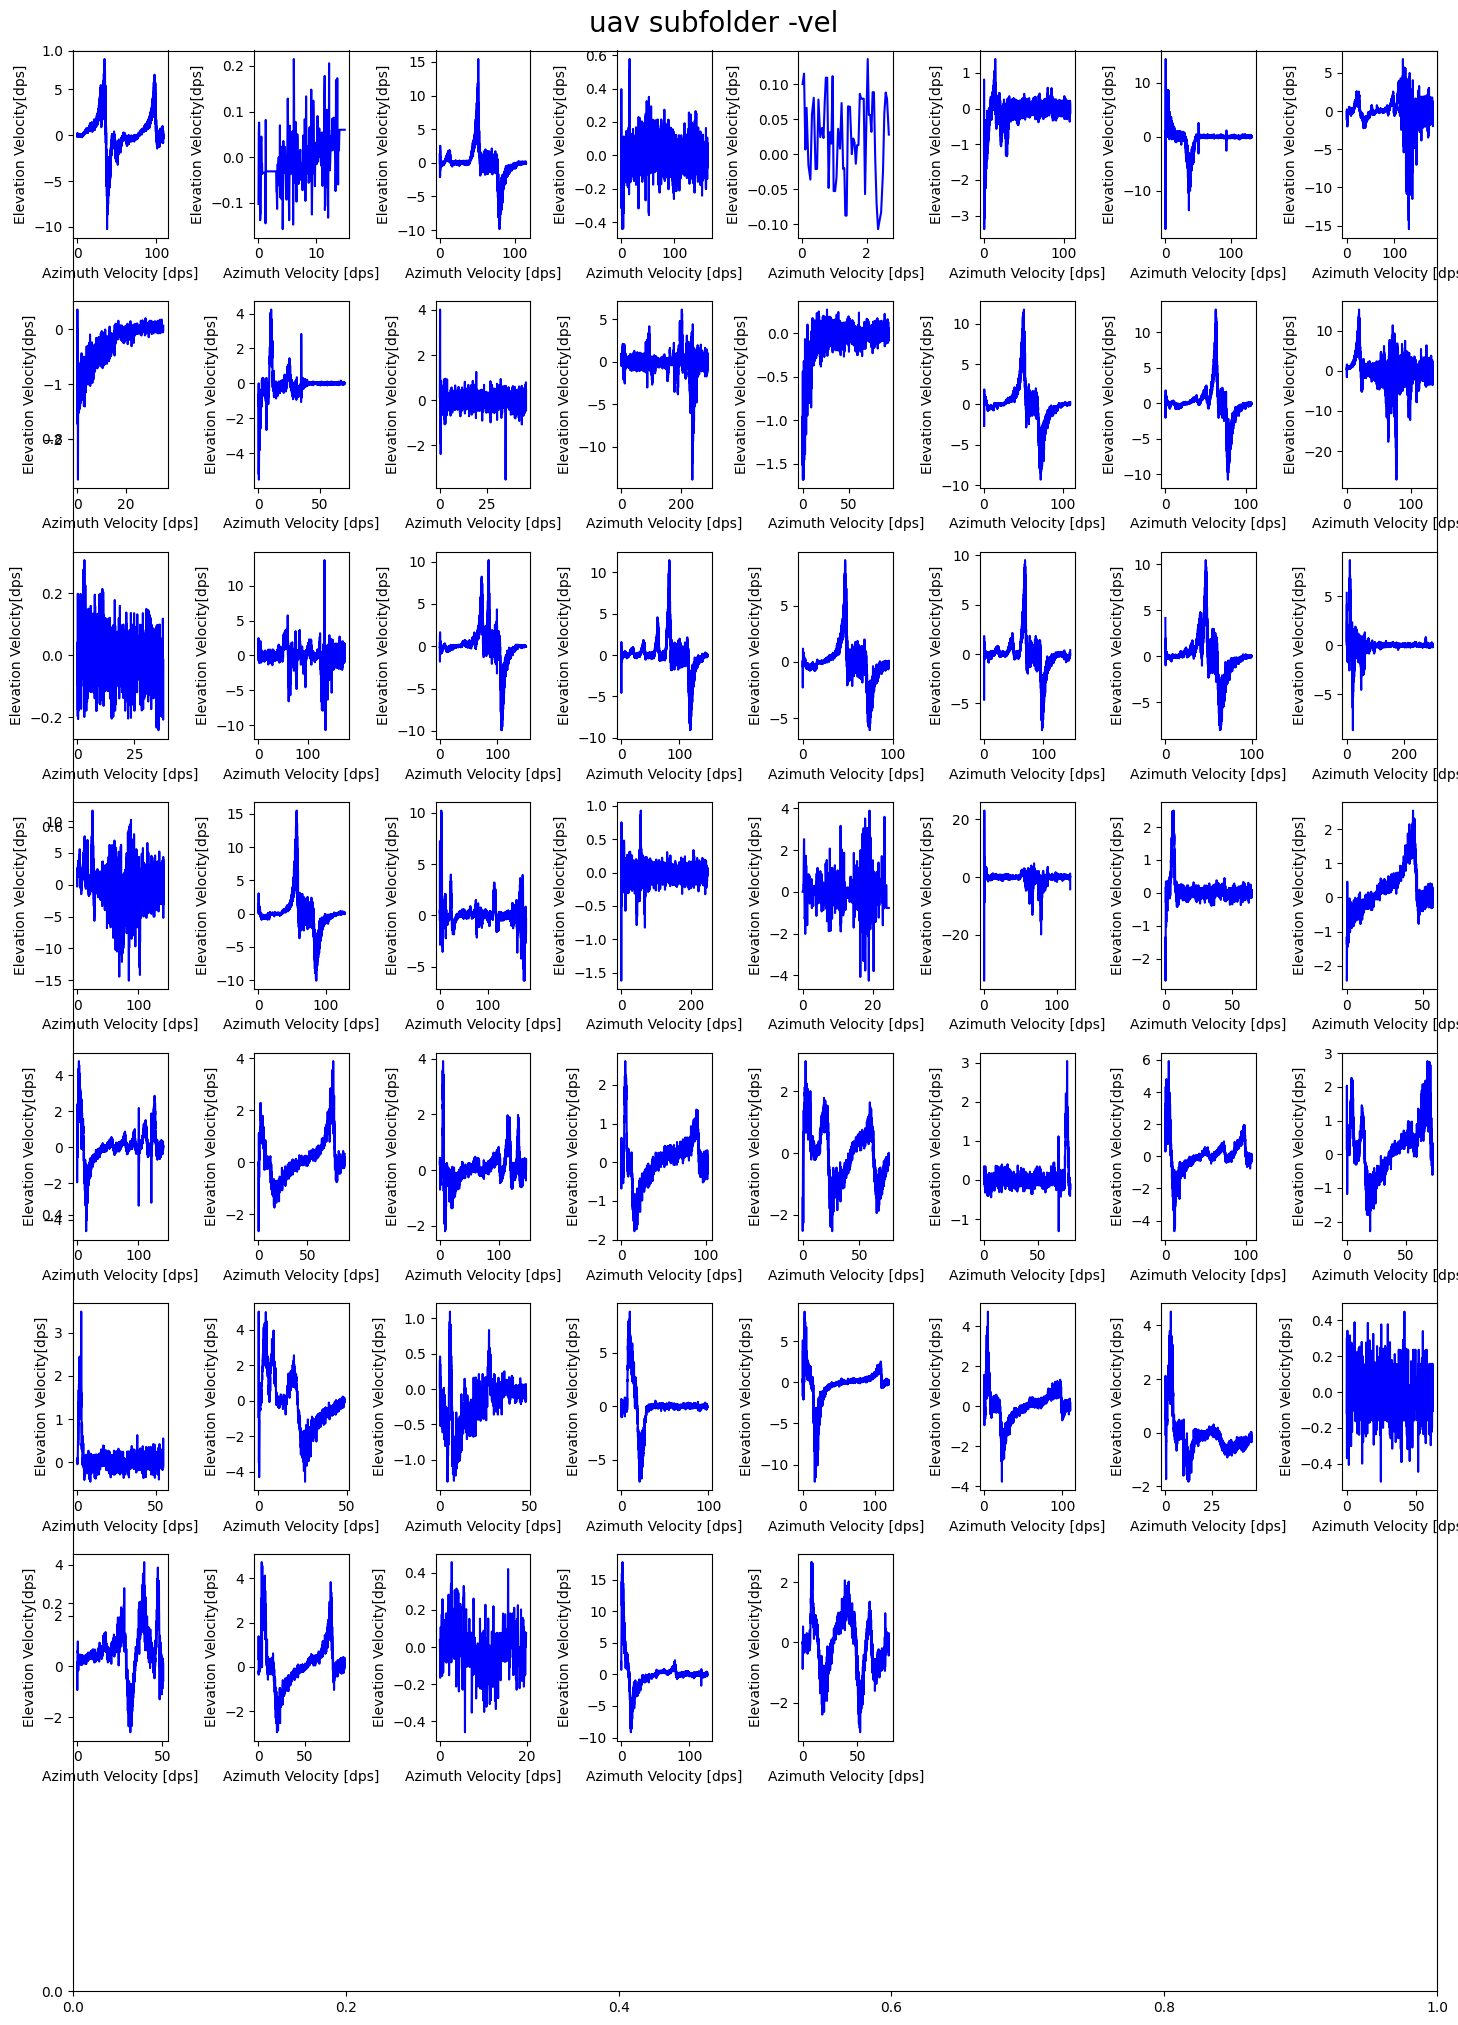

In [ ]:
plot_subfolder("uav", 'vel')